In [37]:
#import required packages
#basics
import pandas as pd 
import numpy as np
#misc
import gc
import time
import warnings
#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
#viz
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

In [33]:
#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [39]:
#settings
pd.set_option('max_columns',1000)
pd.options.display.float_format = '{:,.8f}'.format
start_time=time.time()
color = sns.color_palette()
# sns.set_style("dark")
# sns.set_style('darkgrid')
# sns.set_palette('bone')
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
%matplotlib inline

In [3]:
train = pd.read_csv('/Users/zhangyanpeng/Desktop/TCCC/JTCCC/train.csv')
test = pd.read_csv('/Users/zhangyanpeng/Desktop/TCCC/JTCCC/test.csv')
test_labels = pd.read_csv('/Users/zhangyanpeng/Desktop/TCCC/JTCCC/test_labels.csv')
sample_submission = pd.read_csv('/Users/zhangyanpeng/Desktop/TCCC/JTCCC/sample_submission.csv')
print('train size'+str(train.shape))
print('test size'+str(test.shape))
print('test_labels size'+str(test_labels.shape))
print('sample_submission size'+str(sample_submission.shape))
train.head(5)

train size(159571, 8)
test size(153164, 2)
test_labels size(153164, 7)
sample_submission size(153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
toxic,0.09584448,0.29437877,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
severe_toxic,0.00999555,0.09947714,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
obscene,0.05294822,0.22393083,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
threat,0.00299553,0.05464959,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
insult,0.04936361,0.21662672,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
identity_hate,0.00880486,0.09342049,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000


In [6]:
x = train.iloc[:,2:].sum()
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [7]:
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
print("Total comments       = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags           = ",x.sum())

Total comments       =  159571
Total clean comments =  143346
Total tags           =  35098


In [8]:
train['toxic_index'] = pd.Series(
    train.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1),dtype = int)

In [9]:
train.toxic_index.value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: toxic_index, dtype: int64

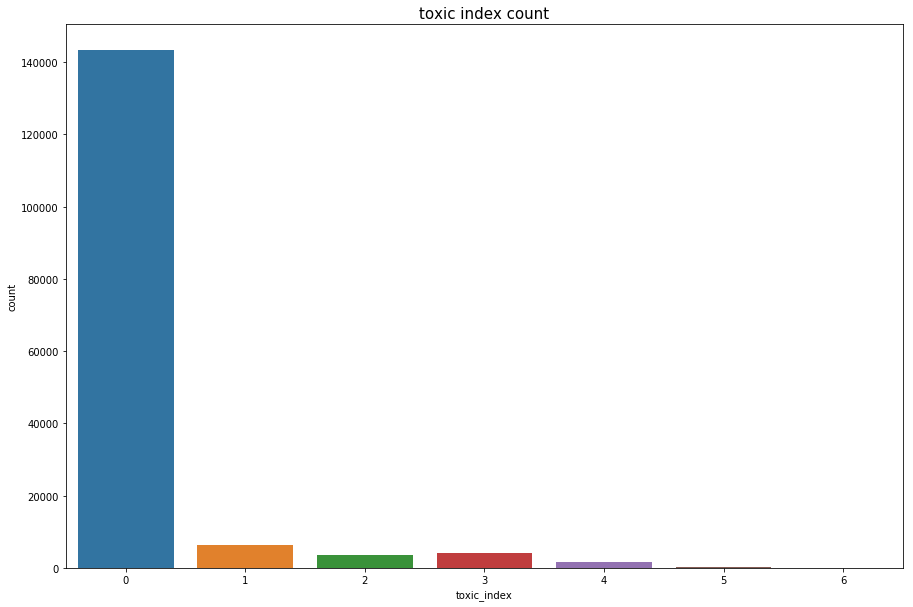

In [36]:
plt.figure(figsize=(15,10))
sns.countplot(train['toxic_index'].sort_values())
plt.grid(False)
plt.title('toxic index count',fontsize = 15)
plt.show()

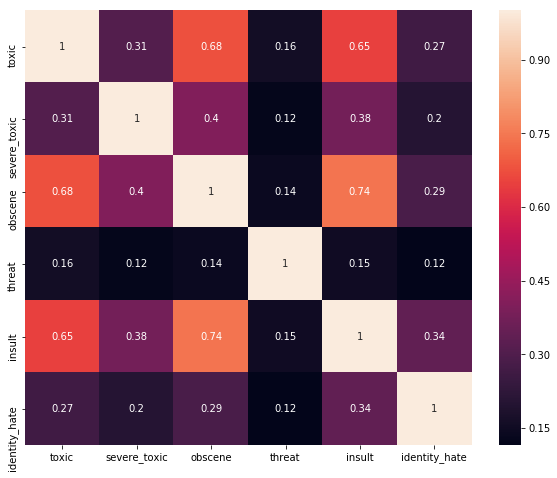

In [14]:
temp_df=train.loc[:,['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [45]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [46]:
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])
#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

In [30]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[2,1])
print(train[train.severe_toxic==1].iloc[6,1])

toxic:
you are a stupid fuck 

and your mother's cunt stinks
Here's an idea 

Go fuck yourself, cumshitter.


In [23]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])
print(train[train.severe_toxic==1].iloc[8,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!
you gay motherfucker i know where you live,i am going to sand your face off,then i am to going to beat you to a pulp,you chicken shagger.


In [26]:
print("Obscene:")
print(train[train.obscene==1].iloc[4,1])
print(train[train.obscene==1].iloc[20,1])

Obscene:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
Fuck you 

-User:The Bohemian Shinobis yeah, that's right, bitch! You are all pieces of shit!


In [27]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])
print(train[train.identity_hate==1].iloc[9,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


# Wordclouds - Frequent words:

In [49]:
!ls /Users/zhangyanpeng/Documents/GitHub/python-Kaggle-TCCC/imagesforkernal/

anger.png            gas-mask.png         swords.png
biohazard-symbol.png megaphone.png        toxic-sign.png
bomb.png             safe-zone.png


In [50]:
stopword=set(STOPWORDS)

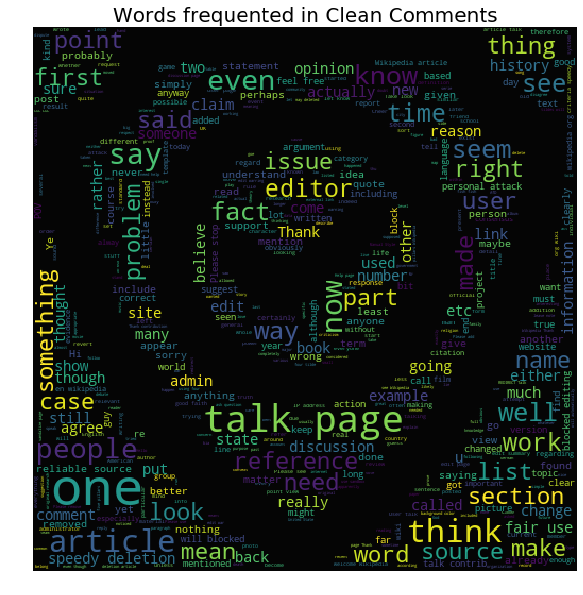

In [51]:
clean_mask=np.array(
    Image.open("/Users/zhangyanpeng/Documents/GitHub/python-Kaggle-TCCC/imagesforkernal/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

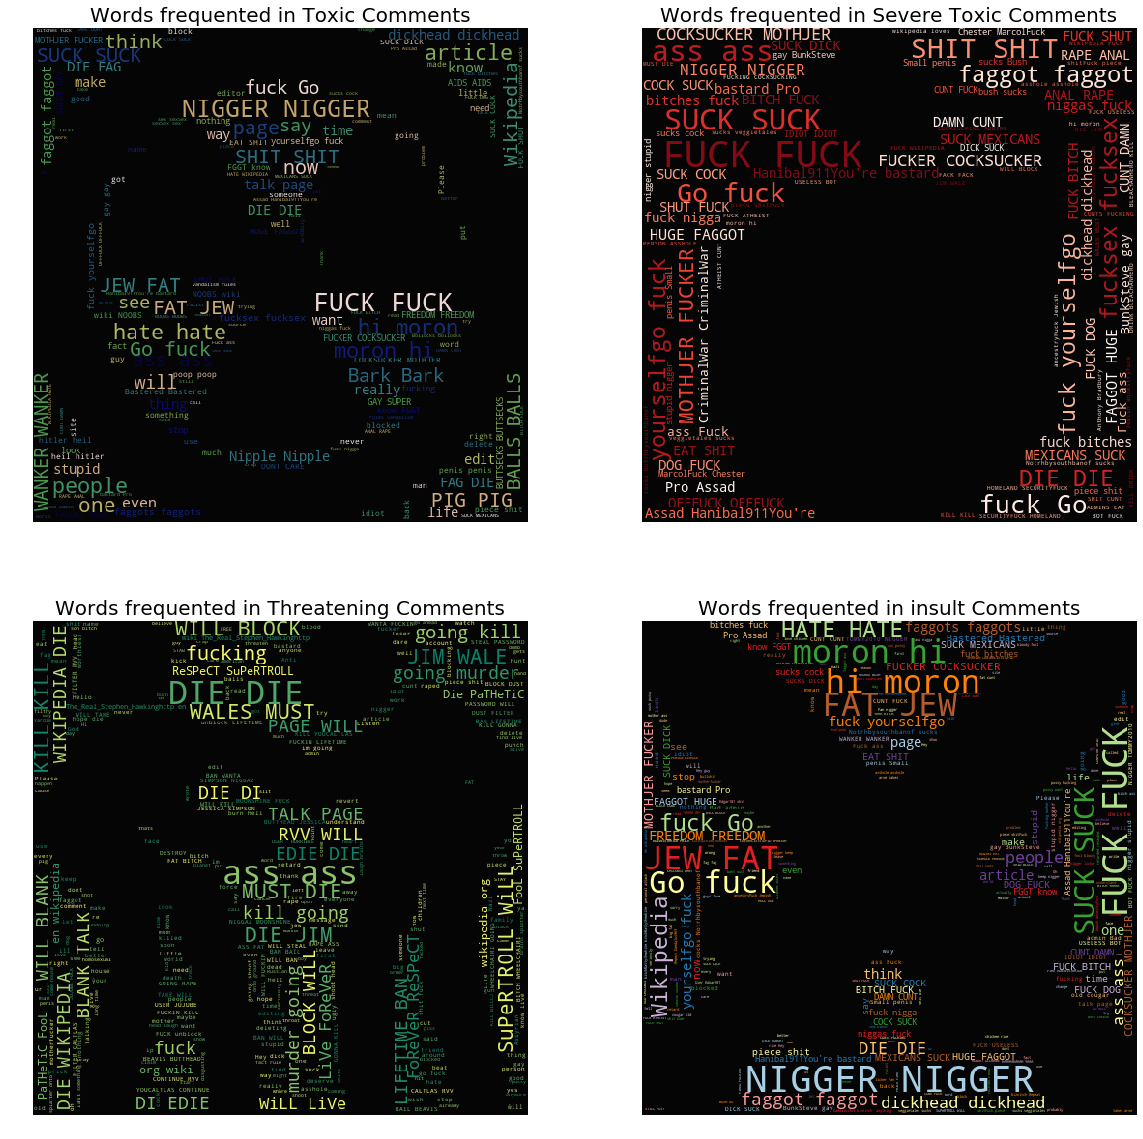

In [53]:
toxic_mask=np.array(Image.open("/Users/zhangyanpeng/Documents/GitHub/python-Kaggle-TCCC/imagesforkernal/toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("/Users/zhangyanpeng/Documents/GitHub/python-Kaggle-TCCC/imagesforkernal/bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("/Users/zhangyanpeng/Documents/GitHub/python-Kaggle-TCCC/imagesforkernal/anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("/Users/zhangyanpeng/Documents/GitHub/python-Kaggle-TCCC/imagesforkernal/swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()